In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import polars as pl
from pathlib import Path
import data_visualization as dv
from time import time
import copy
import importlib
import dill 
import GTO
import dyad_gt_params as param
import constants as const
import plot_functions as pf
import model_functions as mf

Successfully changed to cashaback_dark.mplstyle


# Notebook Outline
## 1. Functions
  - create_single_trial_df: Puts each model trial for perturbations and probes into separate dataframes for plotting

## 2. Parameter Setup
  - Sets up the necessary parameters to run the model

# Functions

In [2]:
def create_single_trial_df(trial, model, state_mapping, condition, p1_target, p2_target, experiment_trial_number):
    df = pl.DataFrame()
    df = df.with_columns(
        timepoint = model.state_timesteps,
        condition = np.array([condition]*len(model.state_timesteps)),
        p1_target = np.array([p1_target]*len(model.state_timesteps)),
        p2_target = np.array([p2_target]*len(model.state_timesteps)),
        trial = np.array([trial]*len(model.state_timesteps)),
        experiment_trial_number = np.array([experiment_trial_number]*len(model.state_timesteps)),
        jump_type = np.array([model.perturbation_states[0]]*len(model.state_timesteps)),
        jump_time = np.array([model.jump_time]*len(model.state_timesteps)),
        jump_back_time = np.array([model.jump_back_time]*len(model.state_timesteps)),
        alpha = np.array([model.alpha]*len(model.state_timesteps),dtype=float),
        partner_knowledge = np.array([model.partner_knowledge]*len(model.state_timesteps)),
        p1_applied_force = np.append(np.array(model.applied_force1), np.nan),
        p2_applied_force = np.append(np.array(model.applied_force2), np.nan),
        u1x = np.append(model.u1[:,0],np.nan),
        u1y = np.append(model.u1[:,1],np.nan),
        u2x = np.append(model.u2[:,0],np.nan),
        u2y = np.append(model.u2[:,1],np.nan),
    )
    for key, val in state_mapping.items():
        df = df.with_columns(pl.Series(key, model.x[:,val]))
    return df

# PLotting Constants

In [9]:
wheel = dv.ColorWheel()
dv.set_plot_style("cashaback_dark.mplstyle")
TRACE_YLIM = (0.025,0.33)
TRACE_XLIM = (0.39,0.73)

involuntary_fontsize = 7.5
pval_fontsize=6
legend_fontsize=8
ylabel_fontsize = 8
experiment_title_fontsize = 9
box_lw = 2

Successfully changed to cashaback_dark.mplstyle


# Parameter Setup

In [3]:
HIT_TIME = 0.8
h=0.01

Q1 = mf.generate_Q(
    weight_dict=param.Q1_WEIGHTS, 
    state_mapping=param.state_mapping, 
    cross_terms=[["ccx","ctx"], ["ccy","cty"], 
                 ["rhy","lhy"]], 
    QVAL=param.QVAL
)
Q2 = mf.generate_Q(
    weight_dict=param.Q2_WEIGHTS, 
    state_mapping=param.state_mapping, 
    cross_terms=[["ccx","ctx"], ["ccy","cty"],
                    ["rhy","lhy"]], 
    QVAL = param.QVAL,
)

# Lists for experimental conditions where a narrow relevant target is QVAL and wide irrelevant target is IRREL_QVAL
Q1_xvals = [
    param.IRREL_QVAL, #  Both irrelevant
    param.QVAL, # P1 Relevant
    param.IRREL_QVAL, # P2 Relevant
    param.QVAL, # Both Relevant
]
Q2_xvals = [
    param.IRREL_QVAL, #  Both irrelevant
    param.IRREL_QVAL, # P1 Relevant
    param.QVAL, # P2 Relevant
    param.QVAL, # Both Relevant
]

# Self Energetic cost matrices
R11 = np.eye(param.B1.shape[1])*param.RVAL # Square Enery cost matrix with dimensions according to the columns of B
R22 = np.eye(param.B2.shape[1])*param.RVAL # Square Enery cost matrix with dimensions according to the columns of B

# Defines the models 
# (No Partner Representation/Self Cost, Partner Representation/Self Cost, Partner Representation/Equal Joint Cost, Partner Representation/Weighted Joint Cost)
partner_knowledges = [False, True, True, True]
alphas = [0.0, 0.0, 1.0, 0.5]

# Select perturbation type
jump_type = "ccx" # Can change this to "ccx" (center cursor x-pos) or "ctx" (target x-pos)
if jump_type == "ctx":
    perturbation = -param.perturbation_distance
else:
    perturbation = param.perturbation_distance
    
state_mapping = param.state_mapping

# Run Models

In [7]:
SAVE = False # Don't save model objects unless necessary
ANIMATE = False # Set to true to create animations
NUM_TRIALS = 1 # Set number of trials to run
SAVE_PATH = Path(r"..\..\model_data") # Saves the model objects and animations

# Create dictionaries and lists to store dataframe information
regular_models = {}
probe_models = {}
regular_df_list = []
probe_df_list = []

# Loop through each model
for i in range(len(alphas)):
    print(f"model {i+1}")
    c = 0 # experiment trial number counter
    # Loop through conditions (self and partner target widths)
    for j in range(len(Q1_xvals)):
        # Set Qval for P1 and P2 according to experimental condition
        Q1[state_mapping['ccx'],state_mapping['ccx']] = Q1_xvals[j]
        Q1[state_mapping['ccx'],state_mapping['ctx']] = -Q1_xvals[j]
        Q1[state_mapping['ctx'],state_mapping['ccx']] = -Q1_xvals[j]
        Q2[state_mapping['ccx'],state_mapping['ccx']] = Q2_xvals[j]
        Q2[state_mapping['ccx'],state_mapping['ctx']] = -Q2_xvals[j]
        Q2[state_mapping['ctx'],state_mapping['ccx']] = -Q2_xvals[j]
        
        model = GTO.GameTheoryLQG(
            name = const.model_condition_names[j],
            p1_target=param.player_relevancy[j][0],
            p2_target=param.player_relevancy[j][1],
            partner_knowledge=partner_knowledges[i],
            alpha=alphas[i],
            x0 = param.x0, # Initial state, 
            A = param.A, 
            B1 = param.B1,
            B2 = param.B2,
            Q1 = Q1,
            Q2 = Q2,
            R11 = R11,
            R22 = R22,
            R12 = R22*alphas[i], # P1 caring about P2's energtic cost
            R21 = R11*alphas[i], # P2 caring about P1's energtic cost
            C1 = param.C1, 
            C2 = param.C2, 
            sensor_noise_arr1 = param.SENSOR_NOISE_ARR1,
            sensor_noise_arr2 = param.SENSOR_NOISE_ARR2,
            process_noise_value =  param.PROCESS_NOISE,
            internal_model_noise_value=param.INTERNAL_MODEL_NOISE,
            W1_cov = param.W1_cov,
            W2_cov = param.W2_cov,
            V1_cov = param.V1_cov,
            V2_cov = param.V2_cov,
            sensory_delay=param.sensory_delay_steps,
            perturbation=perturbation,
            h=h,
            HIT_TIME=HIT_TIME,
            probe_duration=param.probe_duration_steps,
            perturbation_states=jump_type,
            LQR=False, # Set to True for no noise
            probe_trial=False, # Set's to true below for probe trials
            state_mapping = state_mapping,
        )
        
        # Q vals should be the same for both players in Joint Irrelevant and Joint Relevant conditions
        # for ccx position and on (ccx, ccy, ctx, cty)
        idx = state_mapping['ccx']
        if j==0 or j==3:
            assert np.all(model.MS.Q1[idx:,idx:] == model.MS.Q2[idx:,idx:])
            
        model.add_kalman_filter()
        model.add_feedback_gain()
        
        probe_model = copy.deepcopy(model)
        probe_model.probe_trial = True
        if SAVE:
            with open(SAVE_PATH / f"perturbation_p1_{param.player_relevancy[j][0]}_p2_{param.player_relevancy[j][1]}_"
                                    f"jumptype_{jump_type}_" 
                                    f"perturbation_{perturbation}_"
                                    f"alpha_{alphas[i]}_"
                                    f"partnerknowledge_{partner_knowledges[i]}.pkl","wb") as f:
                dill.dump(model,f)
            with open(SAVE_PATH / f"probe_p1_{param.player_relevancy[j][0]}_p2_{param.player_relevancy[j][1]}_"
                                    f"jumptype_{jump_type}_"
                                    f"perturbation_{perturbation}_"
                                    f"alpha_{alphas[i]}_"
                                    f"partnerknowledge_{partner_knowledges[i]}.pkl","wb") as f:
                dill.dump(probe_model,f)
                
        #* Create long format data for trials
        for k in range(NUM_TRIALS):
            c+=1
            model.run_simulation()
            model.calculate_cost()
            probe_model.run_simulation()
            probe_model.calculate_cost()
            regular_df = create_single_trial_df(trial=k+1, model=model,
                                    state_mapping=state_mapping, condition=model.name,
                                    p1_target = model.p1_target,
                                    p2_target = model.p2_target, 
                                    experiment_trial_number = c)
            regular_df_list.append(regular_df)
            
            probe_df = create_single_trial_df(trial=k+1, model=probe_model,
                                                state_mapping=state_mapping, condition=probe_model.name,
                                                p1_target = probe_model.p1_target,
                                                p2_target = probe_model.p2_target, 
                                                experiment_trial_number=c)
            probe_df_list.append(probe_df)
        
        regular_models[const.model_condition_names[j]] = copy.deepcopy(model)
        probe_models[const.model_condition_names[j]] = copy.deepcopy(probe_model)
    
    # TODO Fill this out
    if ANIMATE:
        pass

# Stitch dataframes together to create one long format dataframe
regular_df = pl.concat(regular_df_list)
probe_df = pl.concat(probe_df_list)

models = mf.Models(regular_df, probe_df, alphas=alphas, partner_knowledges=partner_knowledges)


model 1
model 2
model 3
model 4


# Plots

## Trajectories

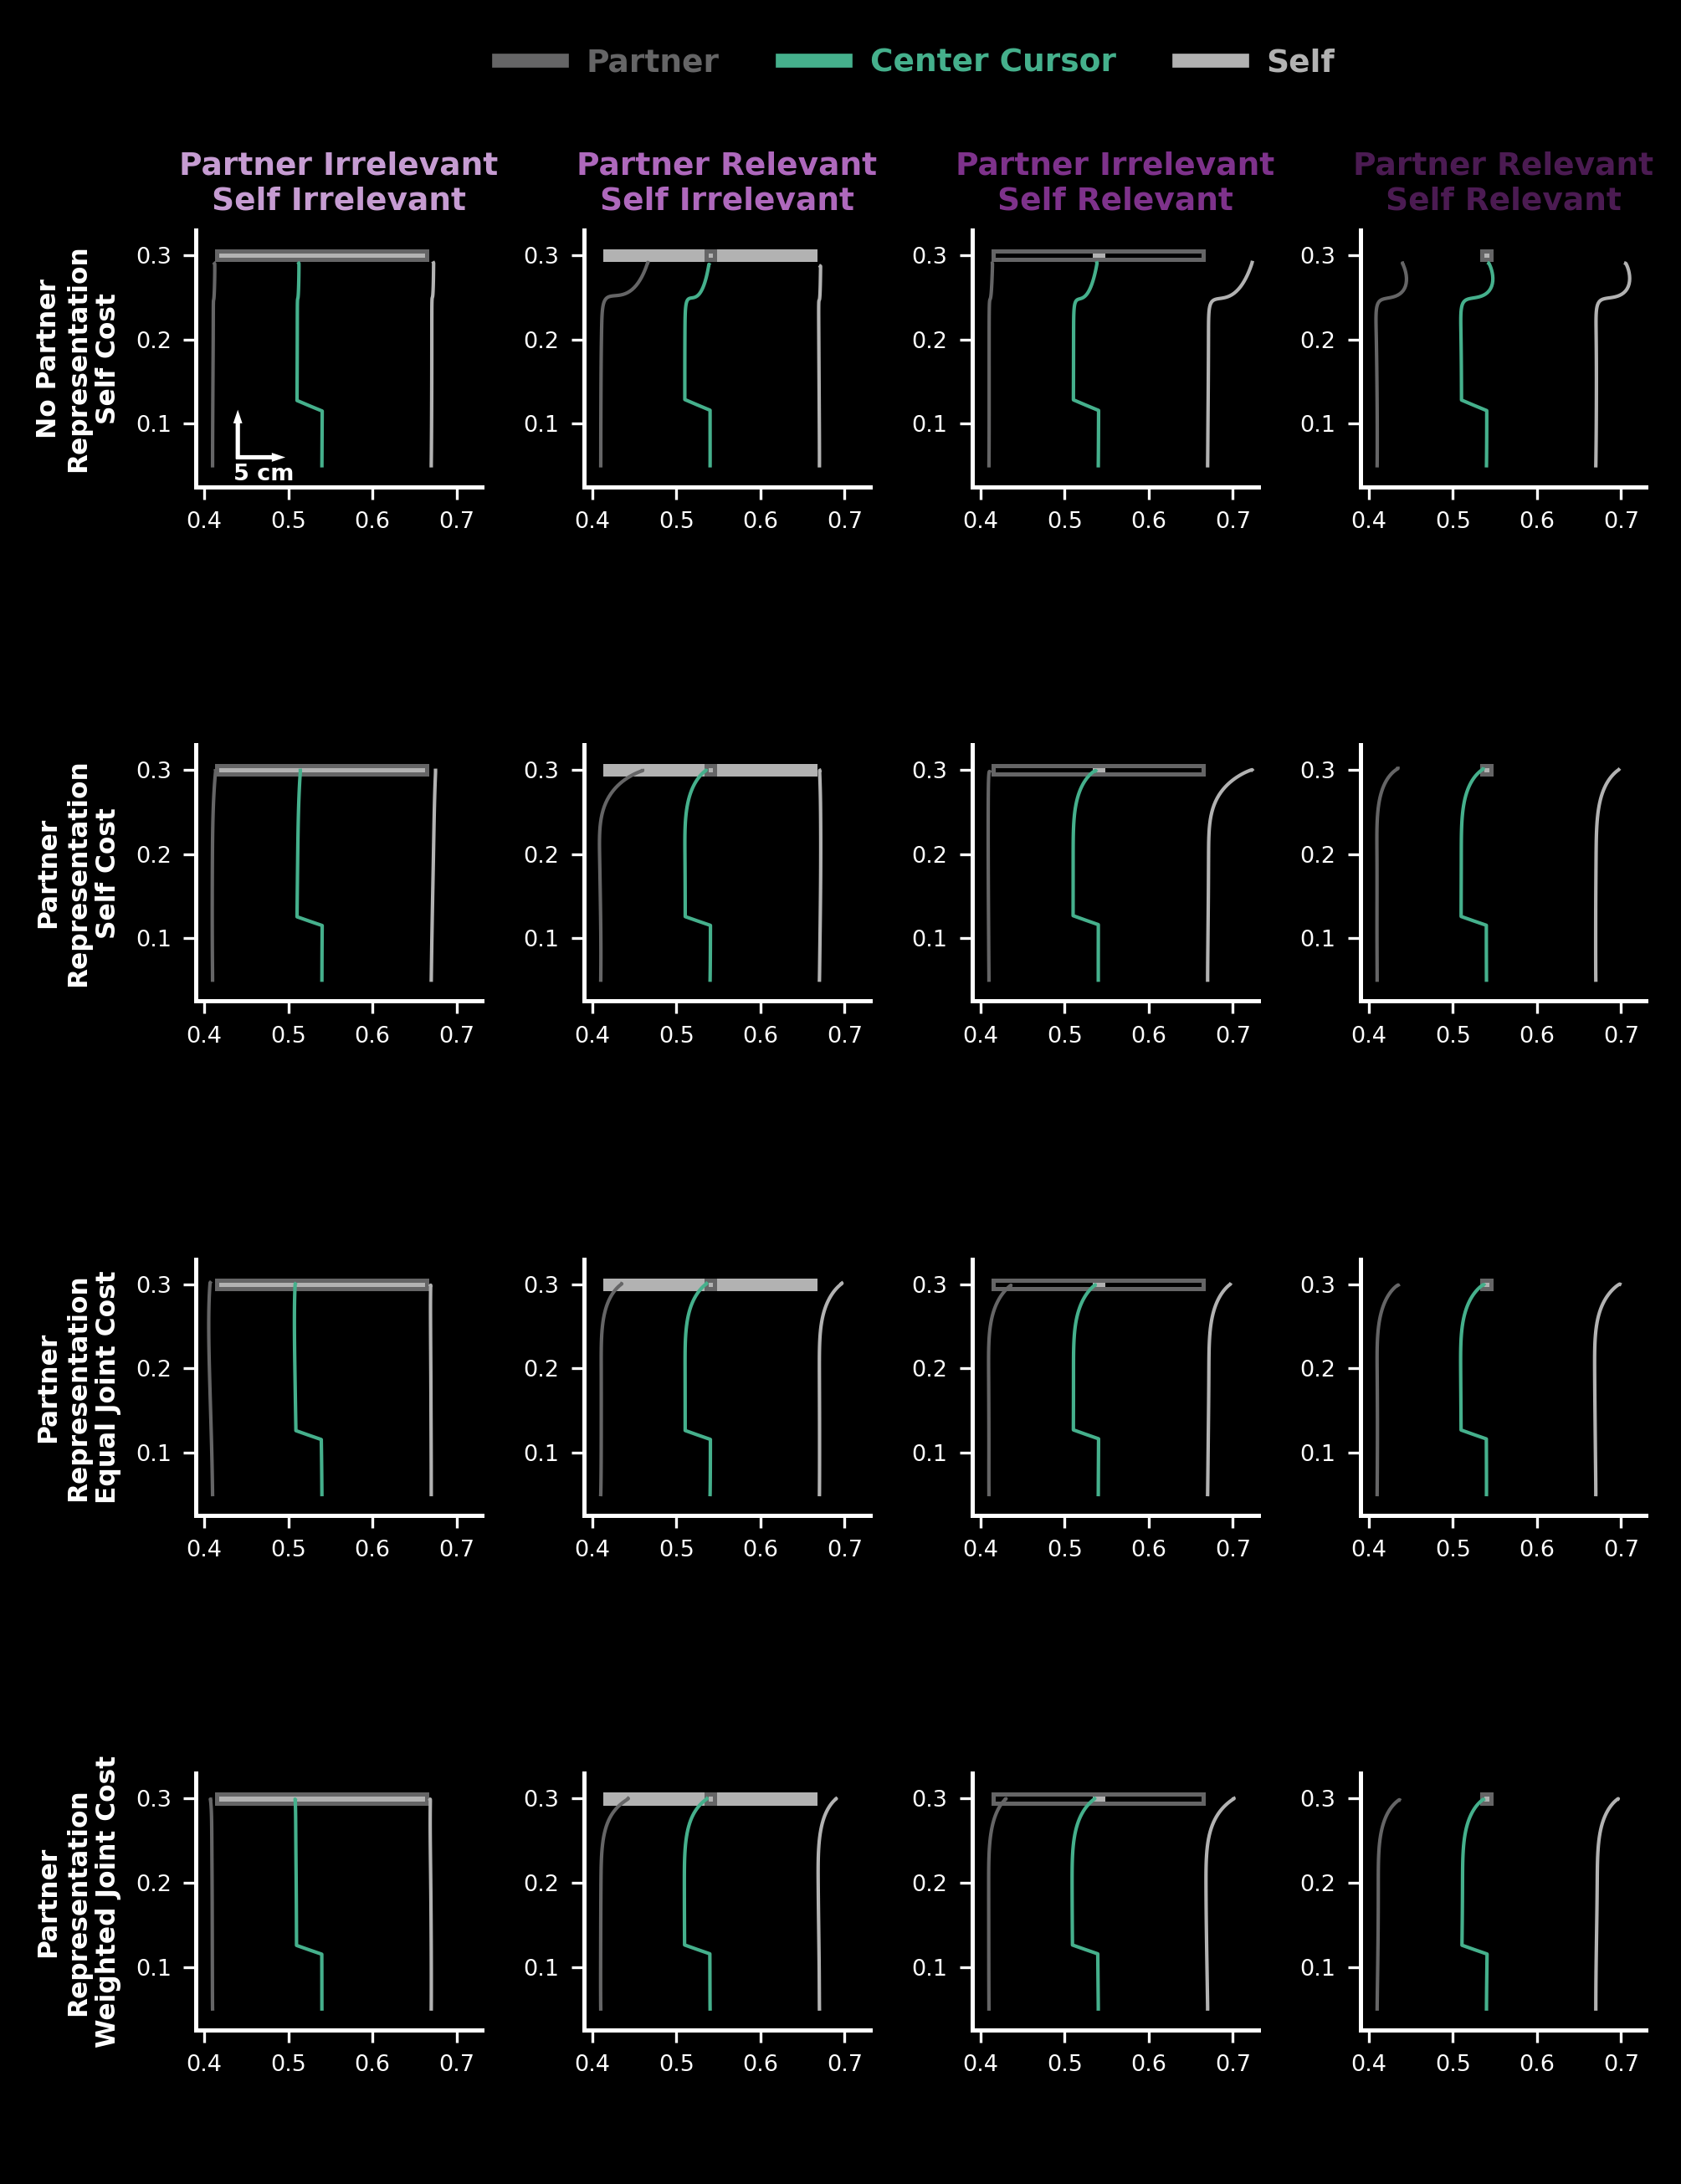

In [10]:
mosaic = [ 
    ["leg","leg","leg","leg"],
    ["a","b","c","d"],
    ["e","f","g","h"],
    ["i","j","k","l"],
    ["m","n","o","p"],
]
player_relevancy = [
    ("irrelevant","relevant"),
]
fig = dv.AutoFigure(
    mosaic=mosaic, figsize=(6.5,8.5), dpi=300, 
    height_ratios=[0.01,1,1,1,1], hspace=0
)
axes = list(fig.axes.values())
for i,(alpha,partner_knowledge,model_name) in enumerate(zip(alphas, partner_knowledges, const.model_condition_names)):
    for j,condition in enumerate(const.flipped_target_types):
        ax = fig.axes[mosaic[1+i][j]]
        df = regular_df.filter(
            pl.col("alpha")==alpha,
            pl.col("partner_knowledge")==partner_knowledge,
            pl.col("p1_target") == const.target_types_to_p1_p2_target_type[condition]["p1"],
            pl.col("p2_target") == const.target_types_to_p1_p2_target_type[condition]["p2"]
        )

        rhx = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("rhx").mean())["rhx"].to_numpy()).squeeze() + 0.54 # THESE are so I can use my targets in the right spot
        rhy = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("rhy").mean())["rhy"].to_numpy()).squeeze() + 0.05
        lhx = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("lhx").mean())["lhx"].to_numpy()).squeeze() + 0.54
        lhy = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("lhy").mean())["lhy"].to_numpy()).squeeze() + 0.05
        ccx = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("ccx").mean())["ccx"].to_numpy()).squeeze() + 0.54
        ccy = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("ccy").mean())["ccy"].to_numpy()).squeeze() + 0.05
        
        ax.plot(rhx, rhy,c=const.self_color,zorder=10,alpha=1, lw=1)
        ax.plot(lhx, lhy,c=const.partner_color,zorder=10,alpha=1, lw=1)
        ax.plot(ccx, ccy,c=const.cc_color,zorder=10,alpha=1, lw=1,)  
        
        # Plot STD
        rhx_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("rhx").std())["rhx"].to_numpy()).squeeze() # THESE are so I can use my targets in the right spot
        rhy_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("rhy").std())["rhy"].to_numpy()).squeeze()
        lhx_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("lhx").std())["lhx"].to_numpy()).squeeze()
        lhy_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("lhy").std())["lhy"].to_numpy()).squeeze()
        ccx_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("ccx").std())["ccx"].to_numpy()).squeeze()
        ccy_std = np.vstack(df.group_by("timepoint", maintain_order=True).agg(pl.col("ccy").std())["ccy"].to_numpy()).squeeze()
        
        under_line_rh = rhx -  2*rhx_std
        over_line_rh = rhx +  2*rhx_std
        ax.fill_betweenx(rhy, under_line_rh, over_line_rh, zorder=1,
                        color=const.self_color, alpha=0.5, edgecolor='none')   
        
        under_line_lh = lhx -  2*lhx_std
        over_line_lh = lhx +  2*lhx_std
        ax.fill_betweenx(lhy, under_line_lh, over_line_lh, zorder=1,
                        color=const.self_color, alpha=0.5, edgecolor='none')   
        
        under_line_cc = ccx -  2*ccx_std
        over_line_cc = ccx +  2*ccx_std  
        ax.fill_betweenx(ccy, under_line_cc, over_line_cc, zorder=1,
                        color=const.cc_color, alpha=0.5, edgecolor='none')
        
        p1_targets, p2_targets = pf.get_target_patches(ax, self_color=const.self_color, 
                                                        partner_color=const.partner_color, 
                                                        border_width=1.2, edge_alpha=1, face_alpha=1)
        ax.add_patch(p1_targets[condition])
        ax.add_patch(p2_targets[condition])
        
        # ax.set_yticks([])
        # ax.set_xticks([])
        # ax.set_xticklabels([])
        # ax.set_yticklabels([])
        # ax.spines[['left','bottom']].set_visible(False)
        ax.set_xlim(TRACE_XLIM)
        ax.set_ylim(TRACE_YLIM)
        if i == 0:
            ax.set_title(const.collapsed_condition_names[j], fontsize=9, 
                    color=const.collapsed_condition_colors_light[j], fontweight="bold", 
    )
        ax.set_aspect("equal")
        

# Add scale
ax = fig.axes['a']
arrow_x = 0.44
arrow_y = 0.06
ax.arrow(arrow_x, arrow_y, 0.05, 0, length_includes_head=True, head_width = 0.005, shape="full", fc="black", transform=ax.transData)
ax.arrow(arrow_x, arrow_y, 0.0, 0.05, length_includes_head=True, head_width = 0.005, shape="full", fc="black", transform=ax.transData)
# ax.annotate("hello", xy=(0.36, 0.26), xytext=(0, 0.),
#             arrowprops=dict(arrowstyle="->"), transform=ax.transData)
ax.text(arrow_x-0.005, arrow_y-0.0075, "5 cm", va='top', ha='left', transform=ax.transData, fontweight="bold", fontsize=6.5)
    
fig.axes['a'].set_ylabel(const.model_names_threelines[0], fontsize=7.5)
fig.axes['e'].set_ylabel(const.model_names_threelines[1], fontsize=7.5)
fig.axes['i'].set_ylabel(const.model_names_threelines[2], fontsize=7.5)
fig.axes['m'].set_ylabel(const.model_names_threelines[3], fontsize=7.5)
    
labels = ["Partner", "Center Cursor", "Self"]
colors = [
    const.partner_color,
    const.cc_color,
    const.self_color,
]
dv.legend(
    fig.axes['leg'],
    labels=labels,
    colors=colors,
    ncols=len(labels),
    columnspacing=2,
    fontsize=9,
    loc=(0.2,0),
    # bbox_to_anchor=(0.5, 0.975),
)
fig.axes['leg'].set_axis_off()
fig.remove_figure_borders()
plt.show()

## Lateral Deviation

## Visuomotor Feedback Responses

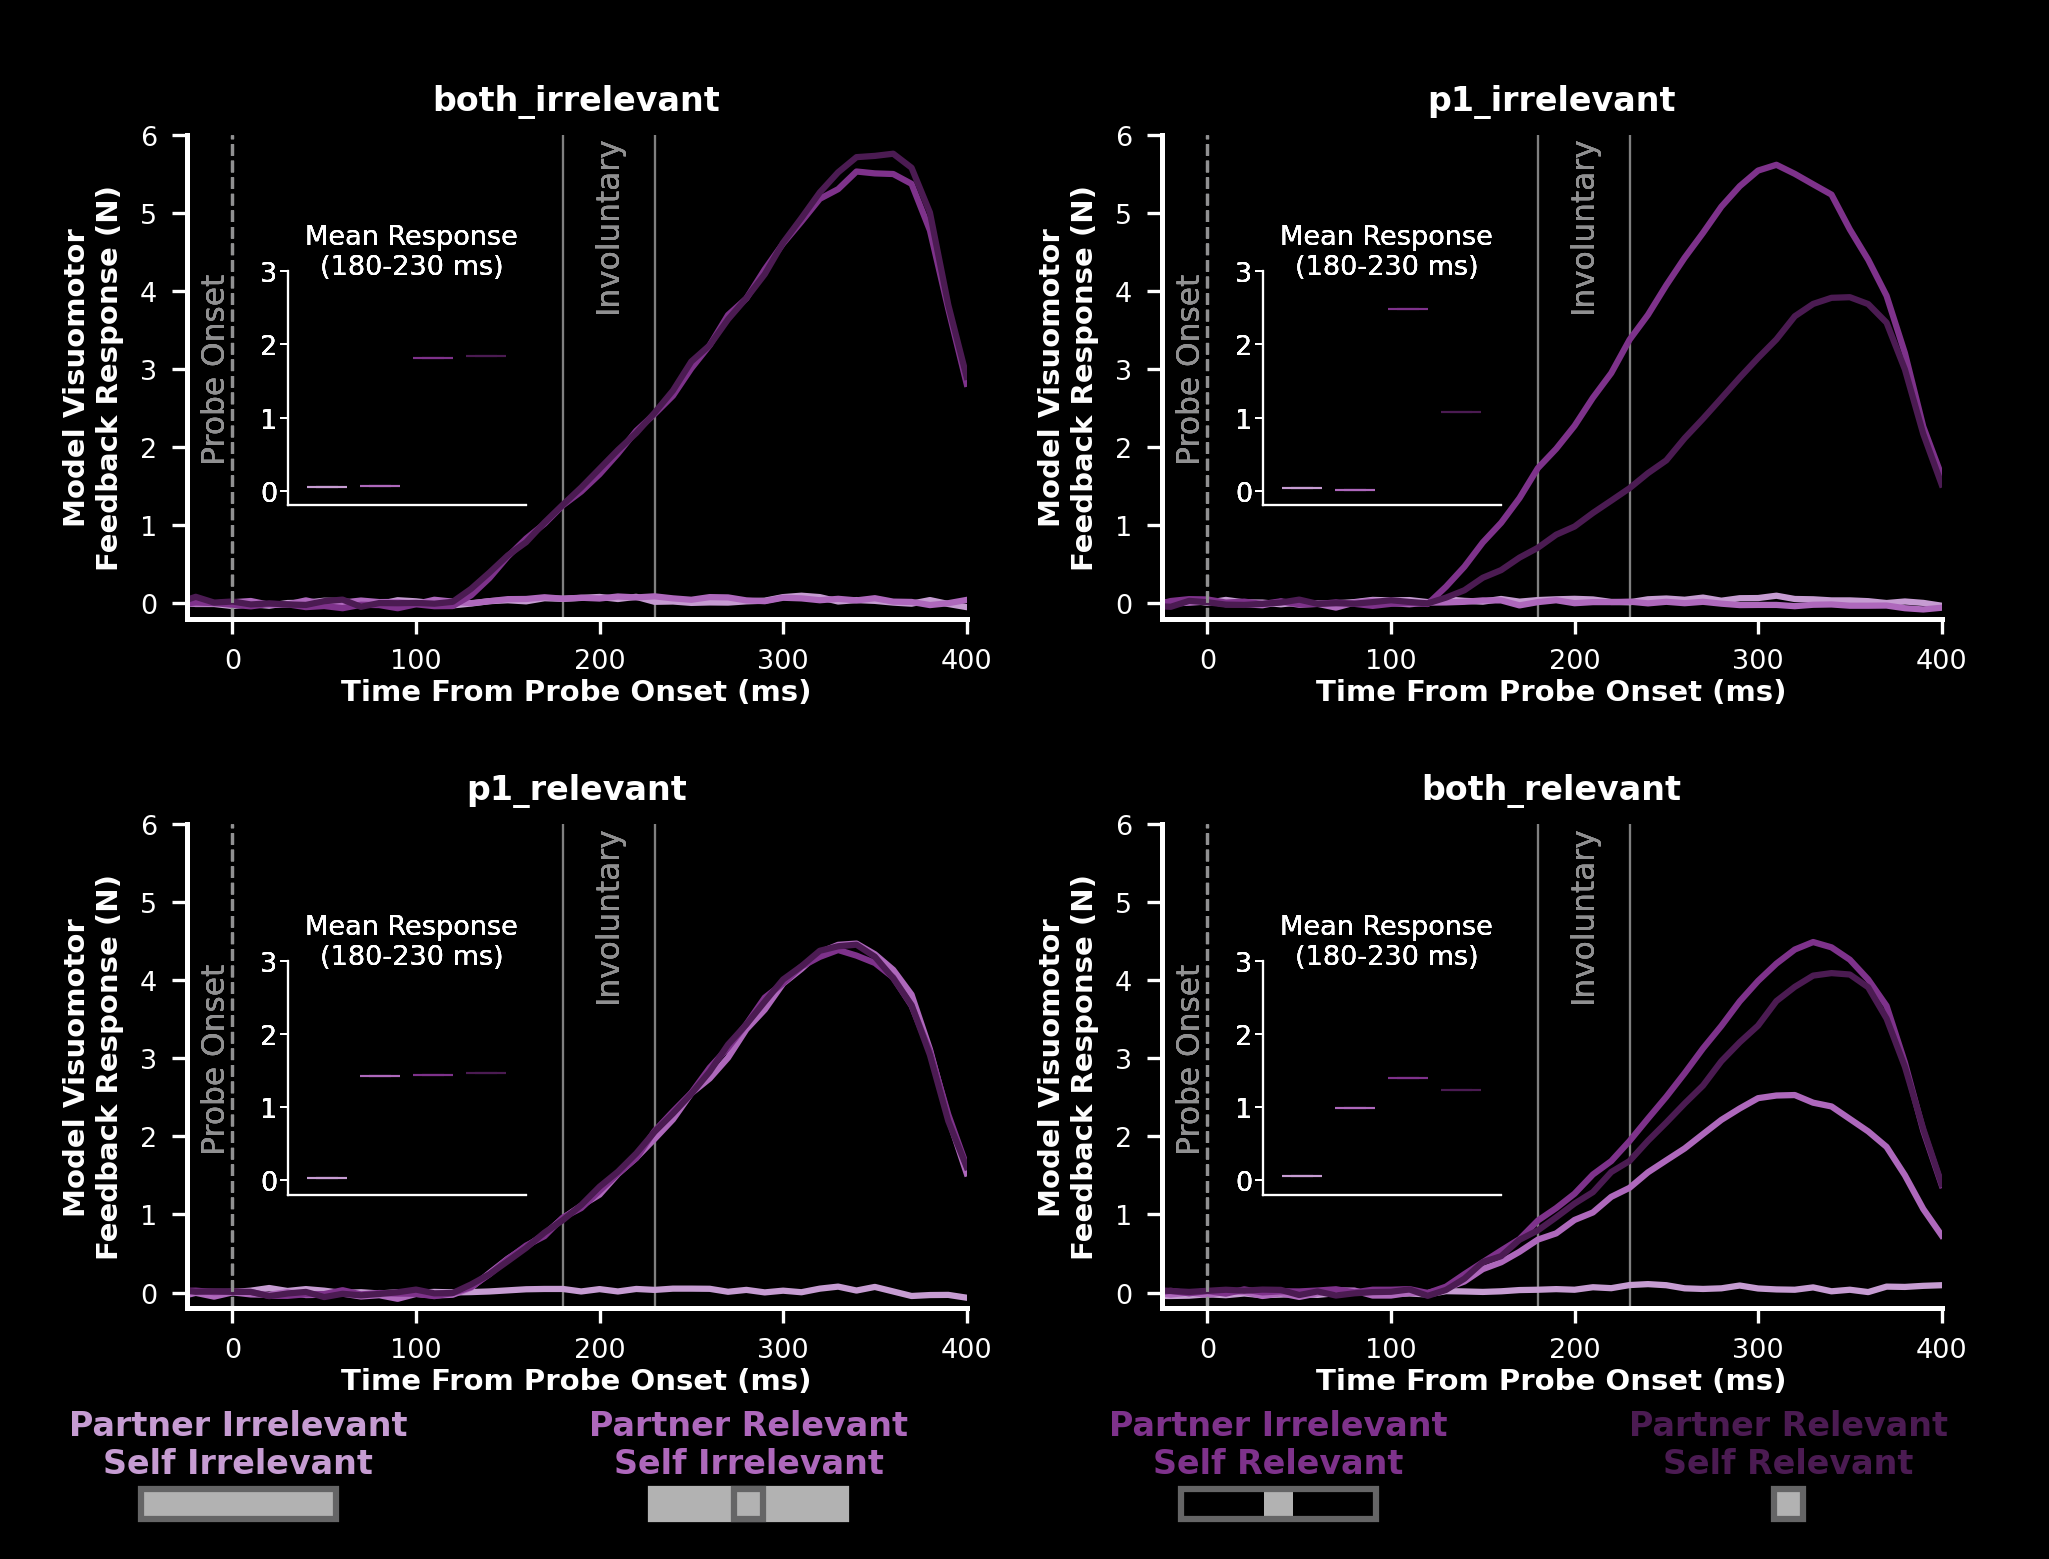

In [ ]:
# %%
#* A priori Model (Traces with Involuntary Inset)
if True:
    xticks = np.arange(0,401,100)
    mosaic = [ 
            ["a","b"],
            ["c","d"],
            ["leg","leg"],
    ]
    ylim = (-0.2,6)
    fig = dv.AutoFigure(mosaic=mosaic, dpi=300, figsize=(6.5,5), height_ratios = [1,1,0.25])
    axes = list(fig.axes.values())
    box_xlocs = np.arange(0,4,1)

    for i,(alpha,partner_knowledge,model_name) in enumerate(zip(alphas, partner_knowledges,const.model_condition_names)):
        ax = axes[i]
        for j,relevancy in enumerate(const.COLLAPSED_PLAYER_RELEVANCY):
            df = models.cropped_probe_df.filter(
                pl.col("alpha")==alpha,
                pl.col("partner_knowledge")==partner_knowledge,
                pl.col("p1_target") == relevancy['self'],
                pl.col("p2_target") == relevancy['partner']
            )
            
            #* PLot traces
            dff = df.group_by("time_from_probe_onset", maintain_order=True).agg(pl.col("p1_applied_force_double").mean())
            rfx = dff["p1_applied_force_double"]
            ax.plot(dff["time_from_probe_onset"], rfx, color=const.collapsed_condition_colors_light[j], label=const.collapsed_condition_names[j]) 
            
            # Plot error ribbons
            rfx_sd = df.group_by("time_from_probe_onset", maintain_order=True).agg(pl.col("p1_applied_force_double").std())["p1_applied_force_double"].to_numpy()

            under_line_rh = rfx - rfx_sd
            over_line_rh  = rfx + rfx_sd
            ax.fill_between(dff["time_from_probe_onset"], under_line_rh, over_line_rh, 
                            color=const.collapsed_condition_colors_light[j], alpha=0.4)        

            # Plot probe onset
            ax.axvline(x=0, ls="--", c= wheel.grey,lw=0.75)
            ax.text(0,ylim[1]/2,"Probe Onset", rotation=90, va='center', ha='right', color=wheel.grey, fontsize=involuntary_fontsize)
            
            # Plot involuntary region
            # ax.fill_betweenx(np.arange(ylim[0],ylim[1],0.01), 180, 230, facecolor = wheel.lighten_color(wheel.light_grey,0.75), alpha = 0.1)
            ax.text(205,ylim[-1],"Involuntary", rotation=90, va='top', ha='center', color=wheel.grey, fontsize=involuntary_fontsize)
            ax.axvline(x=180, color='grey', ls='-', lw=0.5, zorder=-10)
            ax.axvline(x=230, color='grey', ls='-', lw=0.5, zorder=-10)

            ax.set_xticks(xticks)
            ax.set_ylabel("Model Visuomotor\nFeedback Response (N)", fontsize=7)
            ax.set_xlabel("Time From Probe Onset (ms)", labelpad=1, fontsize=7)
            
            ax.set_ylim(ylim)
            ax.set_xlim(-25,400)
            ax.set_title(model_name, fontsize=8)
            
            #*Boxplots        
            # Plot inset involuntary mean 
            inset_x, inset_y = 30, 1.25
            inset_w, inset_h = 130, 3
            axin = ax.inset_axes([inset_x, inset_y, inset_w, inset_h], transform=ax.transData)
            ylabels = "Left - Right Mean Force\n(180 - 230 ms)"
            # for j,condition in enumerate(const.collapsed_condition_names):
            # filter to be between 180-230 and sum
            dff = df.filter(pl.col("time_from_probe_onset").is_between(180,230)).group_by("trial", maintain_order=True).agg(pl.col("p1_applied_force_double").mean())
            # plot
            dv.boxplot(axin, box_xlocs[j], dff["p1_applied_force_double"], 
                    color=const.collapsed_condition_colors_light[j], label=condition, linewidth=0.5, 
                    box_width=0.75) 

            # Set xticks
            # axin.set_xticks(xlocs)
            axin.set_xticklabels([])
            axin.set_xlim(-0.75,3.75)
            # Set ylabel and ticks
            # axin.set_ylabel(ylabels, fontsize=6.5, labelpad=0.04)
            axin.set_yticks(np.arange(0,5,1), labels=np.arange(0,5,1), fontweight='light')
            # axin.set_title(title, fontsize=12)
            axin.set_ylim(-0.2,3)
            axin.spines[["bottom"]].set_visible(True)
            axin.spines[["bottom","top","right","left"]].set_linewidth(0.5)
            axin.tick_params(bottom=False, width=0.4, length=2, pad=0.5)
            axin.text(0.52,1.2,"Mean Response\n(180-230 ms)", 
                    fontsize=6.5, va='top', ha='center', transform=axin.transAxes, fontweight="light")
            

    #Legend
    fig.axes['leg'].set_position([0.02, 0.005, 1, 0.05])
    xpos = np.linspace(0,0.8,4)
    fig.axes['leg'] = pf.aim2_legend(
        fig.axes['leg'], 
        labels=const.collapsed_condition_names, 
        colors=const.collapsed_condition_colors_light,
        xpos=xpos, ypos=0.55, target_pad=0.12,fontsize=legend_fontsize
    )
    fig.axes['leg'].set_axis_off()

    fig.add_letter(fig.axes['a'], -0.18, 1.19)
    fig.add_letter(fig.axes['b'], -0.18, 1.19)
    fig.add_letter(fig.axes['c'], -0.18, 1.19)
    fig.add_letter(fig.axes['d'], -0.18, 1.19)
    fig.remove_figure_borders()
    plt.show()